In [11]:
import functions
import importlib
importlib.reload(functions)

<module 'functions' from 'c:\\Users\\ivoar\\Documents\\CDIA\\P8\\PDI\\PDI_Projeto_Final\\functions.py'>

In [2]:
imagens = functions.load_and_resize_images()
labels = functions.load_labels()

In [3]:
print(len(imagens), len(labels))

# Pega apenas as chaves que existem nos dois dicionários
common_keys = set(imagens.keys()) & set(labels.keys())

# Filtra os dicionários
imagens = {k: imagens[k] for k in common_keys}
labels = {k: labels[k] for k in common_keys}

print(len(imagens), len(labels))

1907 1907
1907 1907


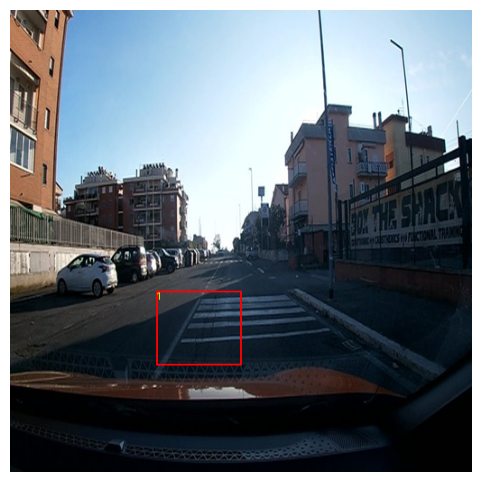

In [16]:
key = list(imagens.keys())[20]  
img = imagens[key]
label_text = labels.get(key, "")

functions.plot_image_with_polygons(img, label_text)

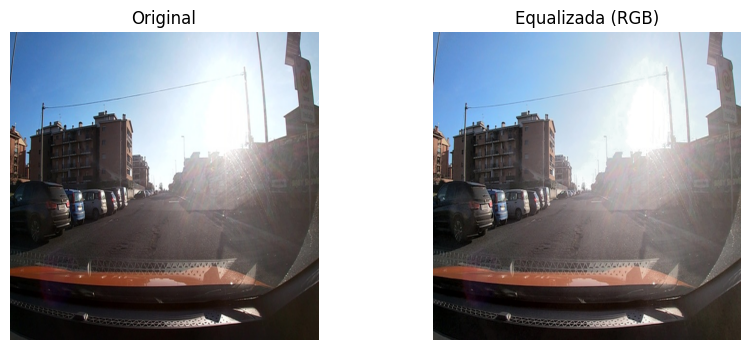

In [18]:
img = imagens[list(imagens.keys())[30]]  # pega uma imagem qualquer
img_eq = functions.equalize_image_rgb(img)


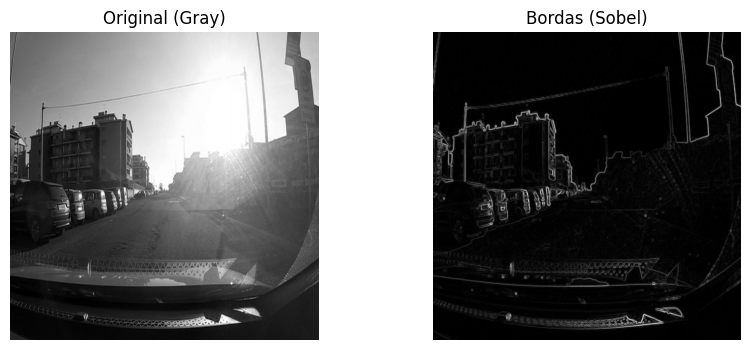

In [17]:
img = imagens[list(imagens.keys())[30]]  # pega uma imagem qualquer
edges_img = functions.sobel_edges(img)
